In [1]:
import zipfile
import os

# Define the path to the ZIP file and the extraction directory
zip_file_path = r'C:\Users\sujib\Downloads\Dataset-2.zip'
extraction_path = r'C:\Users\sujib\Downloads\Dataset-2'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Unzipped files to:", extraction_path)


Unzipped files to: C:\Users\sujib\Downloads\Dataset-2


In [2]:
import os
import csv

# Define the dataset path
dataset_path = r"C:\Users\sujib\Downloads\Dataset-2\Food Classification"
output_csv = os.path.join(dataset_path, "image_labels.csv")

# Collect image paths and labels
entries = []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Only process directories
        label = folder  # The folder name is the label
        for image_file in os.listdir(folder_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, image_file)
                entries.append([image_path, label])

# Write to CSV
with open(output_csv, mode="w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["image_path", "label"])  # Column headers
    writer.writerows(entries)

print(f"CSV file created with {len(entries)} entries at: {output_csv}")



CSV file created with 6269 entries at: C:\Users\sujib\Downloads\Dataset-2\Food Classification\image_labels.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("C:/Users/sujib/Downloads/Dataset-2/Food Classification/image_labels.csv")
print(df.head(15))

                                           image_path   label
0   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
1   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
2   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
3   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
4   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
5   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
6   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
7   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
8   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
9   C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
10  C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
11  C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
12  C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
13  C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger
14  C:\Users\sujib\Downloads\Dataset-2\Food Classi...  burger


In [4]:
df.shape

(6269, 2)

In [5]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [6]:
df['label'].unique()

array(['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature',
       'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi',
       'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos',
       'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'],
      dtype=object)

In [7]:
df['label'].nunique()
# this gives the number of classes

20

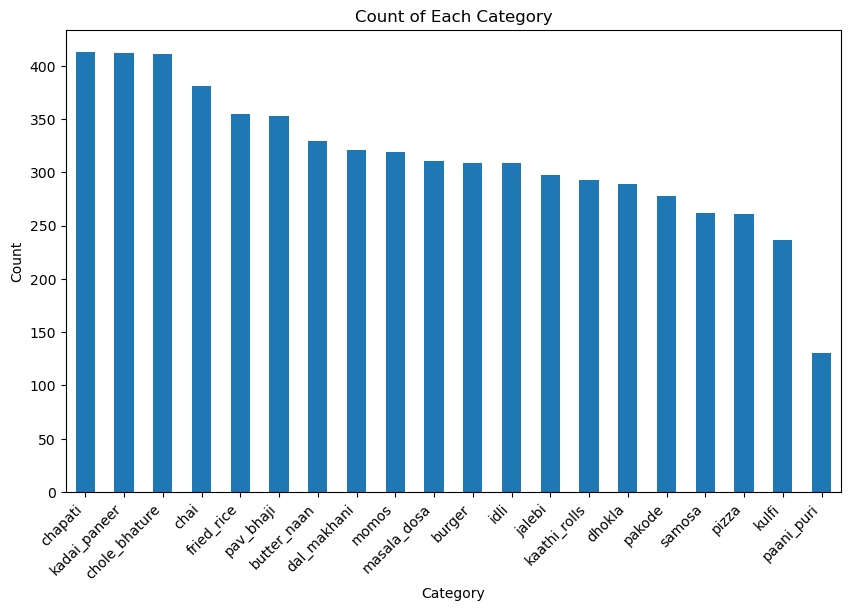

(6269, 2)

In [8]:
import matplotlib.pyplot as plt
category_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Count of Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
df.shape

In [9]:
import os
import numpy as np
import cv2
import zipfile
from io import BytesIO
from PIL import Image

def process_image(image_np):
    # Decode the image as an OpenCV BGR image
    image_bgr = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

    # Check if image was loaded properly
    if image_bgr is None:
        print("Error: Image could not be loaded.")
        return None

    # Convert to HSV to detect the red rectangle
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(image_hsv, (0, 255, 255), (0, 255, 255))

    # Find red rectangle coordinates or default to the entire image
    if np.any(mask):
        y1, y2 = np.min(np.where(mask != 0)[0]), np.max(np.where(mask != 0)[0])
        x1, x2 = np.min(np.where(mask != 0)[1]), np.max(np.where(mask != 0)[1])
    else:
        y1, y2, x1, x2 = 0, mask.shape[0], 0, mask.shape[1]

    # Crop and resize
    image_cropped = image_bgr[y1:y2, x1:x2]
    if image_cropped.size == 0:
        print("Error: Cropped image is empty.")
        return None

    image_resized = cv2.resize(image_cropped, (96, 96))
    return Image.fromarray(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))

def load_and_process_image(file_path, category, unit_id):
    # Load image data and process
    with open(file_path, 'rb') as f:
        image_np = np.asarray(bytearray(f.read()), dtype=np.uint8)
    cropped_image = process_image(image_np)

    if cropped_image is None:
        print(f"Skipping image {file_path} due to processing error.")
        return None, None

    # Save the processed image as bytes
    image_bytes = BytesIO()
    cropped_image.save(image_bytes, format='JPEG')
    return image_bytes.getvalue(), f"{category}/{unit_id}.jpg"

def process_images_in_directory(data_dir, zip_filename, batch_size=100):
    # Initialize zip file and category directories
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for category in os.listdir(data_dir):
            category_path = os.path.join(data_dir, category)
            if not os.path.isdir(category_path):
                continue

            # Process each image in category directory
            for idx, filename in enumerate(os.listdir(category_path)):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(category_path, filename)
                    unit_id = os.path.splitext(filename)[0]  # Using filename as unique ID

                    image_bytes, zip_path = load_and_process_image(file_path, category, unit_id)
                    if image_bytes:
                        zipf.writestr(zip_path, image_bytes)

                    # Batch processing output message
                    if (idx + 1) % batch_size == 0:
                        print(f'Processed {idx + 1} images in category {category}.')

    print("All images zipped successfully.")

# Define paths and run the function
data_dir = r'C:\Users\sujib\Downloads\Dataset-2\Food Classification'
zip_filename = r'C:\Users\sujib\Downloads\images_tuned.zip'
process_images_in_directory(data_dir, zip_filename)


Processed 100 images in category burger.
Processed 200 images in category burger.
Processed 300 images in category burger.
Processed 100 images in category butter_naan.
Processed 200 images in category butter_naan.
Processed 300 images in category butter_naan.
Processed 100 images in category chai.
Processed 200 images in category chai.
Processed 300 images in category chai.
Processed 100 images in category chapati.
Processed 200 images in category chapati.
Processed 300 images in category chapati.
Processed 400 images in category chapati.
Error: Cropped image is empty.
Skipping image C:\Users\sujib\Downloads\Dataset-2\Food Classification\chole_bhature\020.jpg due to processing error.
Processed 100 images in category chole_bhature.
Processed 200 images in category chole_bhature.
Processed 300 images in category chole_bhature.
Processed 400 images in category chole_bhature.
Processed 100 images in category dal_makhani.
Error: Cropped image is empty.
Skipping image C:\Users\sujib\Downloa

In [10]:
import zipfile
import os

zip_path = r'C:\Users\sujib\Downloads\images_tuned.zip'  # Path to your ZIP file
extracted_dir = r'C:\Users\sujib\Downloads\images_extracted'  # Permanent folder path

# Check if extraction folder exists, if not, create it
os.makedirs(extracted_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Extract all contents to the specified directory
        zip_ref.extractall(extracted_dir)
    print("Extraction successful. Files saved to:", extracted_dir)
except zipfile.BadZipFile:
    print("Error: Corrupted ZIP file.")
except Exception as e:
    print("Error occurred during extraction:", str(e))

Extraction successful. Files saved to: C:\Users\sujib\Downloads\images_extracted


In [11]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder  # or DatasetFolder based on your use case
from torchvision import transforms
import torch
import os

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize images to a fixed size
    transforms.ToTensor(),            # Convert to tensor
])

# Define paths to your dataset
dataset_root = r'C:\Users\sujib\Downloads\images_extracted'  # Path to your dataset folder

# Load dataset from the root directory
dataset = ImageFolder(root=dataset_root, transform=transform)

# Calculate dataset size
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print the sizes of the splits
print(f"Train Size: {len(train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")
print(f"Test Size: {len(test_dataset)}")

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Check if CUDA is available and use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Printing a message to indicate completion
print("Data loading completed.")


Train Size: 22676
Validation Size: 2834
Test Size: 2836
Using device: cpu
Data loading completed.


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

# Define device (use GPU if available, else use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the transformations (convert images to tensor, resize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize images to a fixed size
    transforms.ToTensor(),
])

dataset_root = r'C:\Users\sujib\Downloads\images_extracted'

dataset = ImageFolder(root=dataset_root, transform=transform)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print sizes of the splits
print(f"Train Size: {len(train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")
print(f"Test Size: {len(test_dataset)}")

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the ResNet18 model
resnet_model = models.resnet18(pretrained=False)  # Change to pretrained=True if you want pre-trained weights
num_features = resnet_model.fc.in_features

# Define num_classes based on your dataset's class count
num_classes = len(dataset.classes)
resnet_model.fc = nn.Linear(num_features, num_classes)
resnet_model = resnet_model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

# Number of epochs for training
num_epochs = 10

# Lists to store training and validation loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    resnet_model.train()  # Set model to training mode
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track running loss
        running_loss += loss.item() * images.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = (train_correct / train_total) * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    resnet_model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)

            # Track validation loss
            val_loss += loss.item() * images.size(0)

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = (val_correct / val_total) * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print statistics for this epoch
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%')


Using device: cpu
Train Size: 22676
Validation Size: 2834
Test Size: 2836


C:\Users\sujib\anaconda3\envs\GroupB\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sujib\anaconda3\envs\GroupB\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Training Loss: 2.6956, Validation Loss: 2.4754, Train Accuracy: 17.99%, Validation Accuracy: 24.59%
Epoch 2/10, Training Loss: 2.3560, Validation Loss: 2.3861, Train Accuracy: 27.92%, Validation Accuracy: 28.12%
Epoch 3/10, Training Loss: 2.1397, Validation Loss: 2.4392, Train Accuracy: 34.72%, Validation Accuracy: 27.77%
Epoch 4/10, Training Loss: 1.9503, Validation Loss: 2.0412, Train Accuracy: 40.16%, Validation Accuracy: 35.99%
Epoch 5/10, Training Loss: 1.7597, Validation Loss: 2.0600, Train Accuracy: 46.03%, Validation Accuracy: 38.07%
Epoch 6/10, Training Loss: 1.5551, Validation Loss: 2.0775, Train Accuracy: 52.51%, Validation Accuracy: 40.05%
Epoch 7/10, Training Loss: 1.3284, Validation Loss: 1.8743, Train Accuracy: 59.93%, Validation Accuracy: 42.48%
Epoch 8/10, Training Loss: 1.0685, Validation Loss: 1.9153, Train Accuracy: 68.00%, Validation Accuracy: 44.39%
Epoch 9/10, Training Loss: 0.8220, Validation Loss: 1.8891, Train Accuracy: 75.75%, Validation Accuracy:

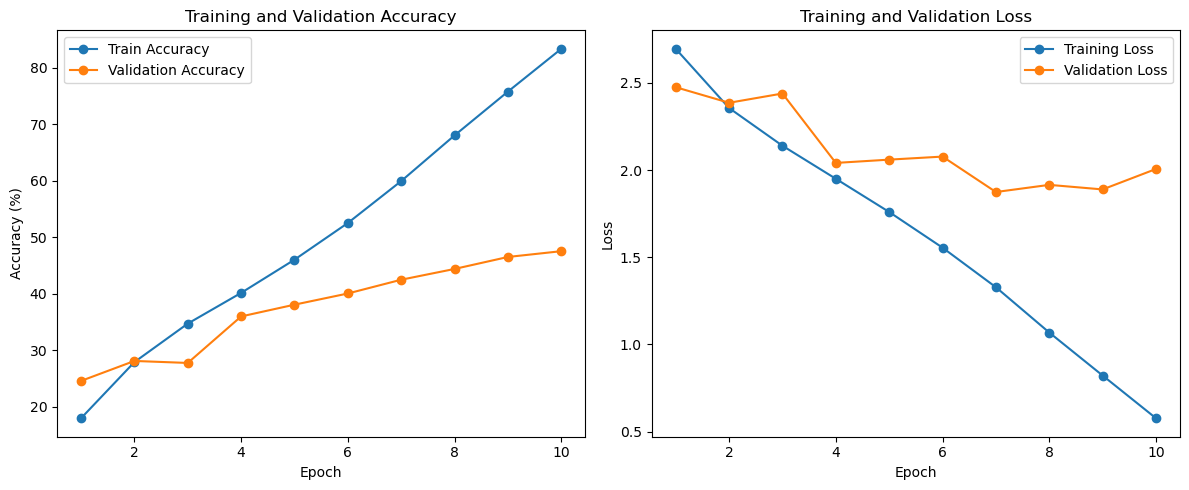

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

# Plot train and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot train and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()
